In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-attack-analysis-prediction-dataset/o2Saturation.csv
/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv


In [2]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,recall_score,accuracy_score

In [3]:
df=pd.read_csv("/kaggle/input/heart-attack-analysis-prediction-dataset/heart.csv")
df['age_group']=df['age'].apply(lambda x: str(x-(x%10))+' to '+str(x+10-(x%10)))
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,age_group
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1,60 to 70
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1,30 to 40
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1,40 to 50
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1,50 to 60
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1,50 to 60


**Description about the variables**
1. exng- Excercise induced Angina. Is a condition where not enough blood is supplied to the walls of heart to pump the blood. It is caused due to excerice or any physcical or mental stress.
2. cp- It describes the type of chest pain experienced. Whether it was typical, atypical angina or non anginal pain or unsymptomatic.
3. trtbps- The resting blood pressure and heart attack have a direct relation. If the resting blood pressure is high then it means that the heart is working hard to pump the required blood and leads to increased chances of heart attack.
4. chol- Cholestrol
5. rest_ecg - The pattern observed in the ECG. It consists of three categories here in the dataset.
            0:Normal  1: Abnormal pattern indicating the lack of blood flow to the heart (Increased chance of heart attack)   2: Pattern that indicates the thickening of the heart muscle of the left ventricle.(Increased chance of heart attack)
6. fbs- Fasting Blood sugar. It is seen that people with higher blood sugar are at more risk of forming clots and hence at more risk of having a heart attack.

# Distribution of variables

In [4]:
temp=pd.value_counts(df['sex'])
px.pie(temp,values='sex',names=['Male','Female'],title='Gender')

In [5]:
temp=pd.value_counts(df['cp'])
px.pie(temp,values='cp',names=['typical angina','non-anginal pain','non-typical angina','asymptomatic'],title='Kind of chest pain')

In [6]:
temp=pd.value_counts(df['output'])
px.pie(temp,values='output',names=['More chances','Less chances'],title='Chances of heart attack')

In [7]:
px.histogram(df,x='age',histnorm='probability',marginal='violin',nbins=20)

In [8]:
px.histogram(df,x='trtbps',histnorm='probability',marginal='violin',nbins=20,opacity=0.8)

In [9]:
px.histogram(df,x='chol',histnorm='probability',marginal='violin',nbins=50)

**Observations**
1. Most people with chest pain where diagnosed with typical angina.
2. Most people fall in the range of 40 to 60.
3. The normal range of Blood pressure is values less than 120 but in our data most values are above this threshold. And Blood pressure greater than 140 is considered high. 20% people have a high blood pressure in the dataset.
4. a cholestrol of 200-240 is considered borderline and above that the cholestrol is considered high.  49.8% people in out data have values above this range.

# Identifying relationships with categorical variables

In [10]:
temp=df.groupby(['cp','output']).agg('count').reset_index()[['cp','output','thall']]
temp['output'].replace({1:'High Chance of heart attack',0:'Low chance of heart attack'},inplace=True)
temp['cp'].replace({0:'typical angina',1:'atypical angina',2:'non-anginal pain',3:'asymptomatic'},inplace=True)
px.bar(temp,x='cp',y='thall',facet_col='output',labels={'cp':'Kind of chest pain','thall':'count','output':'Chances of heart attack'})

75% people from those having a low chance of heart attack have a typical angina while from people having higher chance of a heart attack 41% experience a non-anginal pain.

In [11]:
temp=df.groupby(['age_group','output']).agg('count').reset_index()[['output','age_group','fbs']]
temp_age=df.groupby('age_group').agg('count').reset_index()[['age_group','fbs']]
temp=pd.merge(temp,temp_age,on='age_group')
temp['percentage_of_people']=temp['fbs_x']*100/temp['fbs_y']
temp['output'].replace({1:'High Chance of heart attack',0:'Low chance of heart attack'},inplace=True)
px.bar(temp,x='age_group',y='percentage_of_people',facet_row='output',color='fbs_y',category_orders={'age_group':['20 to 30','30 to 40','40 to 50',
                                                                                 '50 to 60','60 to 70','70 to 80']},
      labels={'fbs_y':'Count of people in age group'})

Bad news if you're in between 40 to 60 years. People in this age group have a higher chance of having an heart attack.

In [12]:
temp=df.groupby(['restecg','output']).agg('count').reset_index()[['restecg','output','thall']]
temp['output'].replace({1:'High Chance of heart attack',0:'Low chance of heart attack'},inplace=True)
temp['restecg'].replace({0:'normal',1:' having ST-T wave abnormality',2:' left ventricular hypertrophy by Estes criteria'},inplace=True)
px.bar(temp,x='restecg',y='thall',facet_row='output',labels={'restecg':'ECG classification','thall':'count','output':'Chances of heart attack'})

In [13]:
temp=df.groupby(['restecg','cp']).agg('count').reset_index()[['restecg','cp','thall']]
temp_ecg=df.groupby('cp').agg('count').reset_index()[['cp','thall']]
temp=pd.merge(temp,temp_ecg,on='cp')
temp['thall']=temp['thall_x']*100/temp['thall_y']
temp['cp'].replace({0:'typical angina',1:'atypical angina',2:'non-anginal pain',3:'asymptomatic'},inplace=True)
temp['restecg'].replace({0:'normal',1:' having ST-T wave abnormality',2:' left ventricular hypertrophy by Estes criteria'},inplace=True)
px.bar(temp,color='restecg',y='thall',x='cp',labels={'restecg':'ECG classification','thall':'Percentage_of_ECG','cp':'Kind of chest pain'},barmode='stack')

In [14]:
df.columns

Index(['age', 'sex', 'cp', 'trtbps', 'chol', 'fbs', 'restecg', 'thalachh',
       'exng', 'oldpeak', 'slp', 'caa', 'thall', 'output', 'age_group'],
      dtype='object')

In [15]:
temp=df.groupby(['caa','output']).agg('count').reset_index()[['caa','output','thall']]
temp['output'].replace({1:'High Chance of heart attack',0:'Low chance of heart attack'},inplace=True)
px.bar(temp,x='caa',y='thall',facet_row='output',labels={'ca':'Number of vessels','thall':'count','output':'Chances of heart attack'})

The number of vessels seems to have a relationship with the risk of heart attack.

# Statistical test for categorical variables
Now lets perform a statistical test to identify the relationship between the categorical variables and the risk of heart attack one after the other.The test is the Chi-squared test which requires a contingency table. Just like with the t-test it too uses the p-value to state whether there is a dependency between the variables or not. When the p-value is less than alpha there will be a dependency otherwise not.

In [16]:
#relationship with kind of chest pain
contingency=[[104,39],[9,41],[18,69],[7,16]]
stat,p,dof,expected=chi2_contingency(contingency)
print('The p-value is ',p)

The p-value is  1.3343043373050064e-17


In [17]:
#relationship with the ecg result
contingency=[[79,68],[56,96],[3,1]]
stat,p,dof,expected=chi2_contingency(contingency)
print('The p-value is ',p)

The p-value is  0.006660598773498031


In [18]:
#reltionship with age_group
contingency=[[0,1],[4,11],[22,50],[60,65],[48,32],[4,6]]
stat,p,dof,expected=chi2_contingency(contingency)
print('The p-value is ',p)

The p-value is  0.005143933195644743


In [19]:
#reltionship with gender
contingency=[[24,72],[114,93]]
stat,p,dof,expected=chi2_contingency(contingency)
print('The p-value is ',p)

The p-value is  1.8767776216941503e-06


In [20]:
temp

,caa,output,thall
0,0,Low chance of heart attack,45
1,0,High Chance of heart attack,130
2,1,Low chance of heart attack,44
3,1,High Chance of heart attack,21
4,2,Low chance of heart attack,31
5,2,High Chance of heart attack,7
6,3,Low chance of heart attack,17
7,3,High Chance of heart attack,3
8,4,Low chance of heart attack,1
9,4,High Chance of heart attack,4


In [21]:
#reltionship with number of blood vessels
contingency=[[45,130],[44,21],[31,7],[17,3],[1,4]]
stat,p,dof,expected=chi2_contingency(contingency)
print('The p-value is ',p)

The p-value is  2.712470211959332e-15


**Observations**
1. All the categorical variables seem to have an influence on the chances of heart attack.
2. Age group is also highly correlated and hence we can drop the absolute age value and just keep the age group of the person.

# Identifying relationship with continuous variables

In [22]:
temp=df.copy()
temp['output'].replace({1:'High Chance of heart attack',0:'Low chance of heart attack'},inplace=True)
temp['cp'].replace({0:'typical angina',1:'atypical angina',2:'non-anginal pain',3:'asymptomatic'},inplace=True)
temp['restecg'].replace({0:'normal',1:' having ST-T wave abnormality',2:' left ventricular hypertrophy by Estes criteria'},inplace=True)
px.histogram(temp,x='chol',facet_row='output',histnorm='probability',labels={'chol':'Cholestrol level'})

In [23]:
px.histogram(temp,x='trtbps',facet_row='output',histnorm='probability',labels={'trtbps':'Resting blood pressure'},nbins=20)

In [24]:
px.histogram(temp,x='thalachh',facet_row='output',histnorm='probability',labels={'thall':'Maximum heart rate '},nbins=20)

**Observations**
1. The maximum heart rate shows some correlation with the target variable. The people with higher chance of a heart attack have a slightly higher as compared to those with the low chance.

# Prediction
The dataset is balanced and hence we can directly split the data into training and test set and move on to the predictions.
**We will only keep the variables that have show correlation with the target as seen above**

In [25]:
df=df[['restecg','cp','caa','thalachh','sex','output']]
df['thalachh']=df['thalachh']/max(df['thalachh'])

In [26]:
#if age group is something you need to include. The model does not show any improvement by adding the age 
#hence I decided to not include it
#age_dict={}
#i=0
#for x in ['20 to 30', '30 to 40', '40 to 50', '50 to 60', '60 to 70', '70 to 80']:
 #   age_dict[x]=i
  #  i+=1
#df['age_group']=df['age_group'].apply(lambda x: age_dict[x])

In [27]:
x=df.drop('output',axis=1)
y=df['output']
X_train,X_test,y_train,y_test=train_test_split(x,y,test_size=0.25,random_state=32)

In [28]:
forest=RandomForestClassifier(max_depth=4,n_estimators=250)
forest.fit(X_train,y_train)
print('The accuracy on the training set= ',forest.score(X_train,y_train)*100,'%')

The accuracy on the training set=  85.02202643171806 %


([<matplotlib.axis.YTick at 0x7f2657698c90>,
 [Text(0, 1, 'Actually high risk'), Text(0, 0, 'Actually low risk')])

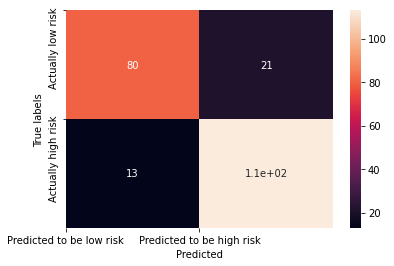

In [29]:
y_train_pred=forest.predict(X_train)
sns.heatmap(confusion_matrix(y_train,y_train_pred),annot=True)
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.xticks([0,1],['Predicted to be low risk','Predicted to be high risk'])
plt.yticks([1,0],['Actually high risk','Actually low risk'])


Some people with high risk are predicted to have a low risk. This is something that can be improved. The recall is what matters here, we do not mind a few people with less risk being predicted as high risk but if a high risk individual is predicted as low risk that is where the problem is. Recall should be used to set the threshold here and not precision or oraccuracy.

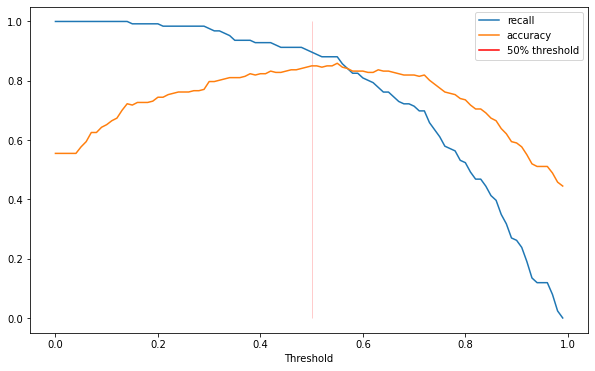

In [30]:
preds=forest.predict_proba(X_train)
recall=[]
accuracy=[]
for thresh in range(0,100):
    p=(preds[:,1]>(thresh/100)).astype(int)
    recall.append(recall_score(y_train,p))
    accuracy.append(accuracy_score(y_train,p))
fig=plt.figure(figsize=(10,6))
sns.lineplot(x=[x/100 for x in range(0,100)],y=recall,label='recall')
sns.lineplot(x=[x/100 for x in range(0,100)],y=accuracy,label='accuracy')
sns.lineplot(x=[0.5,0.5],y=[0,1],label='50% threshold',markers='- -',color='red')
plt.xlabel('Threshold')
plt.legend()

As we can see that at the 50% threshold the recall and the accuracy curves almost intersect. It is also noticeable that if we decrease the threshold to 0.4 there is not going to be much change in the accuracy but the recall is improving considerably. 

The accuracy on the training set after applying threshold at 50.0 % probability is 85.02202643171806 %


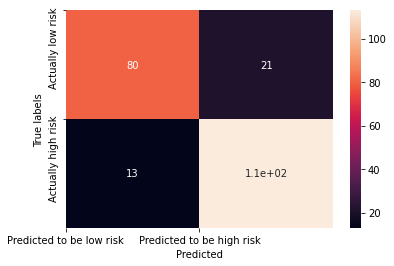

In [31]:
thresh=0.5  #play with the threshold a bit for better results
y_train_pred=forest.predict_proba(X_train)
y_train_pred=(y_train_pred[:,1]>thresh).astype(int)
sns.heatmap(confusion_matrix(y_train,y_train_pred),annot=True)
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.xticks([0,1],['Predicted to be low risk','Predicted to be high risk'])
plt.yticks([1,0],['Actually high risk','Actually low risk'])
print('The accuracy on the training set after applying threshold at',thresh*100,'% probability is',accuracy_score(y_train,y_train_pred)*100,'%')

As seen here that the accuracy decreased a bit but there is much improvement in the recall.

In [32]:
y_preds=forest.predict_proba(X_test)
y_preds=(y_preds[:,1]>thresh).astype(int)
print("The accuracy on the test set after applying threshold for prediction at",thresh*100,"% probability is",accuracy_score(y_test,y_preds)*100,'%')

The accuracy on the test set after applying threshold for prediction at 50.0 % probability is 85.52631578947368 %


([<matplotlib.axis.YTick at 0x7f264f3ae250>,
 [Text(0, 1, 'Actually high risk'), Text(0, 0, 'Actually low risk')])

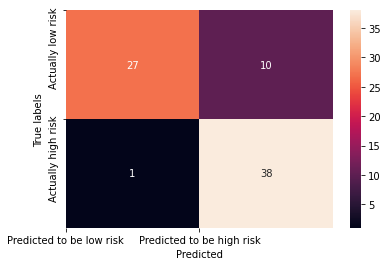

In [33]:
sns.heatmap(confusion_matrix(y_test,y_preds),annot=True)
plt.xlabel('Predicted')
plt.ylabel('True labels')
plt.xticks([0,1],['Predicted to be low risk','Predicted to be high risk'])
plt.yticks([1,0],['Actually high risk','Actually low risk'])

**Without any model tuning we are able to have a considerable accuracy in predicting the chances of heart attack.**